# micro-sam_worm_signal v0.2

NOTE: The first "Run all" is only for environment setup. Do "Run all" again.

0.   Choose runtime : T4 GPU (faster!)
1.   Upload your images in google drive (one folder 📁)
2.   Select pretrained model
3.   Set parameters
4.   Runtime > Run all
5.   Once inference is complete, the download will begin

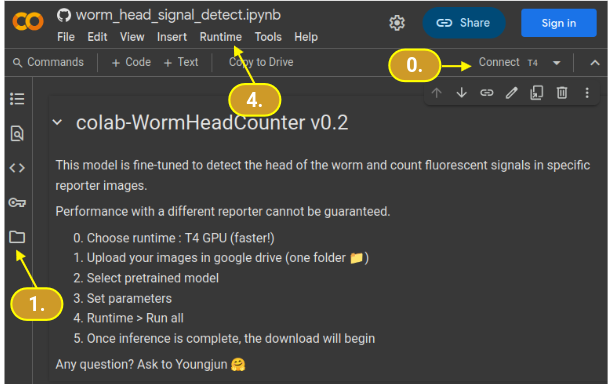

In [ ]:
#@title Set parameters and `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random
import glob

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

pretrained_model_name = "micro-sam_1.4.0" #@param ['micro-sam_1.4.0'] {type:"string"}

#@markdown - Min. segmentation size.
minimun_seg = 6000 #@param {type:"raw"}

#@markdown - The pixel distance between signal peaks affects the total number of detected peaks. (recommend value: 1~10)
min_distance = 2 #@param {type:"raw"}

#@markdown - The peak detection threshold affects the total number of detected peaks. (range: 0.0~1.0)
threshold_abs = 0.05 #@param {type:"raw"}

#@markdown - Remove some pixels from the boundary area.
erosion_param = 1 # @param {type:"slider", min:0, max:10, step:1}

#@markdown - Resize image (x%) before inference?
resize_ratio = 60 # @param {type:"slider", min:0, max:99, step:1}

#@markdown - Please provide the location of the images. To use GoogleDrive, connect drive first (path: /content/drive/MyDrive/...)
raw_image_directory = '/content/drive/MyDrive/yuya' #@param {type:"raw"}


parameter_dic = {
    'pretrained_model_name': pretrained_model_name,
    'minimun_seg': minimun_seg,
    'erosion_param': erosion_param,
}

# Run

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

## Utils

In [ ]:
import condacolab
condacolab.check()

In [ ]:
# Install `micro-sam` and `stackview` (https://github.com/haesleinhuepf/stackview) from `conda-forge`.
!mamba install -y -q -c conda-forge micro_sam stackview > /dev/null 2>&1
!pip uninstall -y --quiet napari  # GUI backends are not supported in Kaggle / Google Colab, let's remove it to avoid errors.

In [ ]:
import stackview

from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

import imageio

from tqdm import tqdm
import pandas as pd
import numpy as np
import glob
import datetime
import pytz
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.morphology import erosion, footprint_rectangle
from skimage.segmentation import find_boundaries
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max
import networkx as nx
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

VERBOSE = False
plt.ioff()

current_date = datetime.datetime.now().astimezone(pytz.timezone('CET'))
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}_{current_date.strftime('%X').replace(':','')}"

parameter_dic['Start_time (CET)'] = datestamp

In [ ]:
def post_process_mask(target_mask, min_seg=4000):
    _new_instances = erosion(target_mask,  footprint_rectangle((5,5)))

    for _ in range(99):
        # Assume labeled_mask with integer labels
        label_ids = np.unique(_new_instances)
        old_num_labels = len(label_ids)
        label_ids = label_ids[label_ids != 0]

        # Create dictionary to hold neighbors
        neighbors = {label: set() for label in label_ids}

        # Pad to avoid border issues
        padded = np.pad(_new_instances, 1)

        # Loop through each label
        for i in label_ids:
            mask_i = (padded == i).astype(np.uint8)
            dilated = cv2.dilate(mask_i, np.ones((3, 3), np.uint8), iterations=1)
            touching = np.unique(padded[(dilated == 1) & (padded != i)])
            for j in touching:
                if j != 0:
                    neighbors[i].add(j)

        edges = []
        # print("Adjacent (touching) label pairs:")
        for i, adj in neighbors.items():
            for j in adj:
                if np.sum(_new_instances == i) >= min_seg and np.sum(_new_instances == j) < min_seg:
                    edges.append((i, j))
                elif np.sum(_new_instances == i) < min_seg and np.sum(_new_instances == j) >= min_seg:
                    edges.append((i, j))


        # Find segments to merge
        G = nx.Graph()
        G.add_nodes_from(label_ids)
        for i, j in edges:
            G.add_edge(i, j)

        # Keep self loop
        for t in (set(np.unique(_new_instances)) - set([int(x) for x in set(G.nodes)])):
            if t != 0 and (np.sum(_new_instances == t) < min_seg):
                G.add_edge(t, t)

        # Step 3: Connected components = merged label groups
        components = list(nx.connected_components(G))

        # Step 4: Create merged mask
        merged_mask = np.zeros_like(_new_instances)
        for new_label, group in enumerate(components, start=1):
            for old_label in group:
                #print(old_label, np.sum(instances == old_label))
                    merged_mask[_new_instances == old_label] = new_label

        _new_instances = merged_mask
        new_num_labels = len(np.unique(_new_instances))

        if old_num_labels == new_num_labels:
            break
        else:
            if VERBOSE == True:
              print(old_num_labels, "!=", new_num_labels)
    return _new_instances

def get_result_a_image(_test_image,
                       _test_mask,
                       image_name,
                       output_dir,
                       out_results,
                       bg_to_remove_level=1,
                       min_distance=10,
                       threshold_abs=0.35,
                       bg_max_value=255,
                       ):
    test_image = _test_image
    filename = os.path.basename(image_name).rstrip('.image.png')

    target_worm_ids = list(sorted(np.unique(_test_mask)))[1:]

    number_of_heads = len(target_worm_ids)
    if VERBOSE == True:
        print(test_image, number_of_heads)

    for region_index in range(number_of_heads):
        target_worm_id = region_index + 1
        mask_patch = np.where(_test_mask == target_worm_id, 1, 0)
        # vis = np.where(mask_patch == 1, 255,0)

        #label_mask = label(mask_patch, background=0, connectivity=10)#, connectivity=1)
        region_box = regionprops(mask_patch)

        rect = None
        for head_id in range(len(region_box)):
            region = region_box[head_id]
            minr, minc, maxr, maxc = region.bbox
            if (maxr-minr)*(maxc-minc) < minimun_seg * 1.5:
                continue
            if VERBOSE == True:
                print(head_id, '#', (maxr-minr)*(maxc-minc))
            rect = mpatches.Rectangle(
                (minc, minr),
                maxc - minc,
                maxr - minr,
                fill=False,
                edgecolor='red',
                linewidth=2,
            )

        if rect == None:
            continue

        fig, axes = plt.subplots(1,4,  figsize=(13,3))
        axes[0].imshow(np.array(test_image))
        axes[0].set_title(f'Orig. View')
        axes[1].imshow(_test_mask, cmap="Paired")
        axes[1].add_patch(rect)
        axes[1].set_title(f'Worm #{target_worm_id}')

        orig_patch = test_image[minr:maxr,minc:maxc]
        mask_patch = mask_patch[minr:maxr,minc:maxc]
        mask_patch = erosion(mask_patch,  footprint_rectangle((erosion_param, erosion_param)))

        if len(orig_patch.shape) > 2:
          orig_patch = orig_patch[:,:,0]
        filt_patch = np.where(mask_patch == 1, orig_patch, 0)
        try:
          br_level = min(bg_to_remove_level, len(np.unique(filt_patch)-1))
          bg_min = np.unique(filt_patch)[br_level]
        except:
          bg_min = np.unique(filt_patch)[0]
        bg_max = bg_max_value
        sum_of_signal = np.sum(filt_patch)/np.sum(mask_patch)

        norm_patch = np.where(filt_patch > bg_max, bg_max, filt_patch)
        norm_patch = np.where(norm_patch < bg_min, bg_min, norm_patch)
        norm_patch = (norm_patch-bg_min)/(bg_max-bg_min)
        axes[2].imshow(filt_patch)
        axes[2].autoscale(False)
        axes[2].set_title('Normalized view')

        #norm_patch = skimage.filters.gaussian(norm_patch, sigma=5)
        #axes[4].imshow(norm_patch)

        # Comparison between image_max and im to find the coordinates of local maxima
        coordinates = peak_local_max(norm_patch, min_distance=min_distance, threshold_abs=threshold_abs, threshold_rel=0.35)
        final_coord = []
        for x in coordinates:
            if mask_patch[x[0], x[1]] != 1:
                continue
            else:
                final_coord.append(x)
        final_coord = np.array(final_coord)
        axes[3].imshow(orig_patch)
        axes[3].autoscale(False)
        axes[3].set_title('Detected peaks')
        if len(final_coord) >0:
            axes[3].plot(final_coord[:, 1], final_coord[:, 0], 'r.')

        #plt.title(f'{filename}-{head_id}:{len(final_coord)}')

        plot_name = f'prediction_file_{filename}_numofheads_{number_of_heads}_headid_{region_index}_bg_{bg_to_remove_level}_mindist_{min_distance}_thrsh_{threshold_abs}.png'
        out_results.append({'filename': filename,
                            'num_of_heads': number_of_heads,
                            'worm_id': target_worm_id,
                            'head_size': np.sum(mask_patch),
                            'peak_cnt': len(final_coord),
                            'peak_per_10k_pixels': len(final_coord)/np.sum(mask_patch)*10000,
                            'avrg_signal': sum_of_signal,
                            'bg_to_remove_level': bg_to_remove_level,
                            'min_distance': min_distance,
                            'threshold_abs': threshold_abs,
                            'output_image_name': plot_name,
                            })
        axes[0].axis("off")
        axes[1].axis("off")
        axes[2].axis("off")
        axes[3].axis("off")
        plt.savefig(f'{os.path.join(output_dir, plot_name)}')
        plt.close(fig)


def save_summary(out_results, output_dir, datestamp):
    model_name_to_save = pretrained_model_name.replace('/','_')
    pd.DataFrame.from_dict(out_results).to_csv(f'{os.path.join(output_dir,f"Summary_model_{model_name_to_save}_run_{datestamp}")}.csv')

In [ ]:
IMAGES = [p for p in glob.glob(os.path.join(f"{raw_image_directory}",'*')) if os.path.isfile(p)]
IMAGES

## micro-SAM Model download

In [ ]:
# Load the Segment Anything for Microscopy model.
predictor, segmenter = get_predictor_and_segmenter(model_type="vit_b_lm")

## Inference

In [ ]:
!rm -rf results_250611_145845


In [ ]:
output_dir = f"./results_{datestamp}"
os.makedirs(output_dir, exist_ok=True)

result_dic = []
for image_path in IMAGES:
    image = imageio.imread(image_path)
    if len(image.shape) > 2:
        image = np.max(image, axis=np.argmin(image.shape))
    target_size = (int(image.shape[0] * resize_ratio / 100), int(image.shape[1] * resize_ratio / 100) )
    image = cv2.resize(image, target_size)

    # Run automatic instance segmentation (AIS) on our image.
    pred_mask = automatic_instance_segmentation(
        predictor=predictor,
        segmenter=segmenter,
        input_path=image,
    )

    post_pred_mask = post_process_mask(pred_mask)

    get_result_a_image(image, post_pred_mask, os.path.basename(image_path), output_dir, result_dic, min_distance=min_distance, threshold_abs=threshold_abs)

save_summary(result_dic, output_dir, datestamp)
pd.DataFrame().from_dict([parameter_dic]).T.to_csv(os.path.join(output_dir, 'configure.txt'))

In [ ]:
download_name = f"c_elegans_entire_signal_{os.path.basename(output_dir)}.zip"
!zip -r {download_name} {output_dir}
from google.colab import files
files.download(f"{download_name}")

# Further information

Issue & contact: https://github.com/iron-lion/microF-Segformer/issues

### Update Log
*   v0.2: Avrg signal added. Image resize param added
*   v0.1: Test

